# Prepare
## Dataset loading

In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import Callback
from tqdm import tqdm

train_raw = pd.read_excel('/home/competition/data/data/ai_competition_train.xlsx')
test_raw = pd.read_excel('/home/competition/data/data/ai_competition_test.xlsx')

train = np.array(train_raw['flux'])
test = np.array(test_raw['flux'])

print(train.shape, test.shape)

#windows shift
INPUT_DAYS = 60


(5479,) (60,)


### NaN to zeros

In [185]:
def nan_to_zero(_input):        
    print("before length:", len(_input))
    # NaN 값을 0.0으로 대체
    print("NaN 값의 개수:", np.sum(np.isnan(_input)))
    nan_indices = np.isnan(train)
    _mask = np.zeros(len(train))
    train[nan_indices] = _mask[nan_indices]
    print("after length:", len(_input))
    return train


### Cut zeros

In [186]:
def cut_zeros(_data):
    print("shape before cut:", _data.shape)
    _data_cut = _data[_data != 0]
    print("shape after cut:", _data_cut.shape)
    return _data_cut

### Make dataset windows shift

In [187]:
def make_dataset_windowsshift(_input, window_size=INPUT_DAYS):
    assert min(_input) > 0
    # subtract mean
    _data = _input.copy()
    
    _data_submean = _data - np.mean(_data)
    
    train_x = np.zeros([INPUT_DAYS, 1])
    train_y = np.zeros([1, 1])

    print("x and y shape :", train_x.shape, train_y.shape)
    for i in range(len(_data_submean) - INPUT_DAYS - 1):
        train_x = np.concatenate(
            (train_x, _data_submean[i:i+INPUT_DAYS, np.newaxis]), axis=1)
        train_y = np.concatenate(
            (train_y, _data_submean[np.newaxis, i+INPUT_DAYS+1, np.newaxis]), axis=1)

    print("x and y shape :", train_x.shape, train_y.shape)
    train_x = train_x[:, 1:]
    train_y = train_y[:, 1:]
    train_x = train_x.T
    train_y = train_y.T
    print("x and y shape :", train_x.shape, train_y.shape)
    
    return train_x, train_y


---

# Model

In [188]:
loss_history = []


class LossHistory(Callback):
    def on_epoch_end(self, epoch, logs=None):
        loss_history.append(logs['loss'])


loss_callback = LossHistory()

model = keras.Sequential()
model.add(keras.layers.LSTM(units=80, input_shape=(INPUT_DAYS, 1)))
model.add(keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['RootMeanSquaredError'])


## First training

In [189]:
train_zeros = nan_to_zero(train)
train_cut = cut_zeros(train_zeros)
train_x, train_y = make_dataset_windowsshift(train_cut)
model.fit(train_x, train_y, epochs=40, batch_size=64, callbacks=[loss_callback])


before length: 5479
NaN 값의 개수: 0
after length: 5479
shape before cut: (5479,)
shape after cut: (4228,)
x and y shape : (60, 1) (1, 1)
x and y shape : (60, 4168) (1, 4168)
x and y shape : (4167, 60) (4167, 1)
Epoch 1/40
66/66 [==============================] - 4s 27ms/step - loss: 787.1353 - root_mean_squared_error: 28.0559
Epoch 2/40
66/66 [==============================] - 2s 27ms/step - loss: 611.7674 - root_mean_squared_error: 24.7339
Epoch 3/40
66/66 [==============================] - 2s 26ms/step - loss: 506.7861 - root_mean_squared_error: 22.5119
Epoch 4/40
66/66 [==============================] - 2s 28ms/step - loss: 438.2910 - root_mean_squared_error: 20.9354
Epoch 5/40
66/66 [==============================] - 2s 28ms/step - loss: 387.5429 - root_mean_squared_error: 19.6861
Epoch 6/40
66/66 [==============================] - 2s 27ms/step - loss: 348.8963 - root_mean_squared_error: 18.6788
Epoch 7/40
66/66 [==============================] - 2s 28ms/step - loss: 319.6653 - root_m

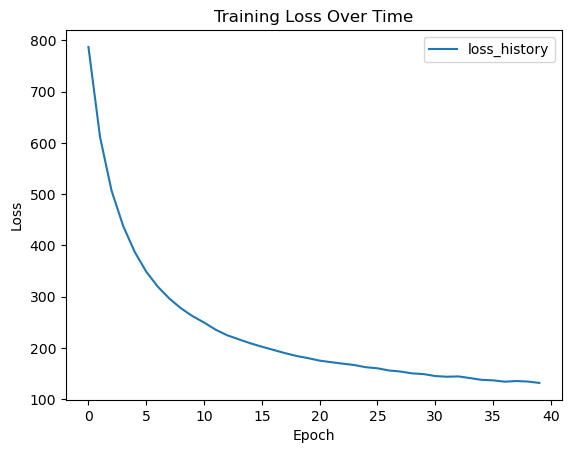

In [190]:

plt.plot(loss_history)
plt.title('Training Loss Over Time')
plt.legend(['loss_history', 'rmse_history'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


## Second training

- zero 다 삭제하고 비뚤어진 데이터셋으로 한 번 학습시킨 다음에
- 동일 모델로 결측값을 예측하고 
- 다시 학습 시키고
- 그것으로 최종 예측하는 2단계 프로세스

### interpolation

In [191]:
# interpolation with LSTM model
_copy = train.copy()
print(train.shape, np.mean(train))

for i in tqdm(range(INPUT_DAYS, len(_copy))):
    if _copy[i] == 0:
        #print(i-INPUT_DAYS-1, i-1, 'i = ',i)
        _copy[i] = model.predict(_copy[i-INPUT_DAYS-1:i-1].reshape(1, INPUT_DAYS, 1), verbose=0)
        
print(_copy.shape, np.mean(_copy))
_copy = cut_zeros(_copy)
print(_copy.shape, np.mean(_copy))


(5479,) 78.29537461215551


  0%|          | 0/5419 [00:00<?, ?it/s]

100%|██████████| 5419/5419 [00:53<00:00, 101.98it/s]

(5479,) 91.71051798876718
shape before cut: (5479,)
shape after cut: (5479,)
(5479,) 91.71051798876718


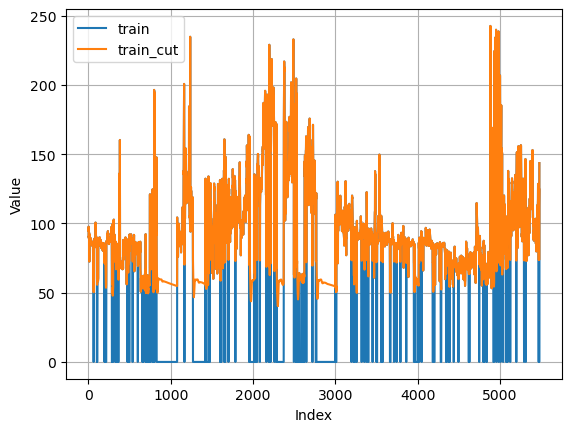

In [192]:
plt.figure()
plt.plot(train, label='train')
plt.plot(_copy, label='train_cut')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

## 0 다시 짜르고, 학습시키기
# 데이터셋만드는 함수 만들기

In [196]:
_copy_zeros = nan_to_zero(_copy)
_copy_cut = cut_zeros(_copy_zeros)
_copy_train_x, _copy_train_y = make_dataset_windowsshift(_copy_cut)
model = keras.Sequential()
model.add(keras.layers.LSTM(units=80, input_shape=(INPUT_DAYS, 1)))
model.add(keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error',
              metrics=['RootMeanSquaredError'])

model.fit(_copy_train_x, _copy_train_y, epochs=40,
          batch_size=64, callbacks=[loss_callback])


before length: 5479
NaN 값의 개수: 0
after length: 5479
shape before cut: (5479,)
shape after cut: (4228,)
x and y shape : (60, 1) (1, 1)
x and y shape : (60, 4168) (1, 4168)
x and y shape : (4167, 60) (4167, 1)
Epoch 1/40
66/66 [==============================] - 5s 29ms/step - loss: 794.3793 - root_mean_squared_error: 28.1847
Epoch 2/40
66/66 [==============================] - 2s 29ms/step - loss: 618.5305 - root_mean_squared_error: 24.8703
Epoch 3/40
66/66 [==============================] - 2s 29ms/step - loss: 515.3857 - root_mean_squared_error: 22.7021
Epoch 4/40
66/66 [==============================] - 2s 29ms/step - loss: 445.9299 - root_mean_squared_error: 21.1171
Epoch 5/40
66/66 [==============================] - 2s 29ms/step - loss: 391.6910 - root_mean_squared_error: 19.7912
Epoch 6/40
66/66 [==============================] - 2s 29ms/step - loss: 351.8346 - root_mean_squared_error: 18.7573
Epoch 7/40
66/66 [==============================] - 2s 29ms/step - loss: 321.5845 - root_m

# Prediction

---

- input 60개로 61번째 예측
- 2번째 ~ 61번째로, 62번째 예측
- 90번째를 예측할 때 까지 반복하고, 61~90번째를 제출

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:01<00:00, 17.11it/s]


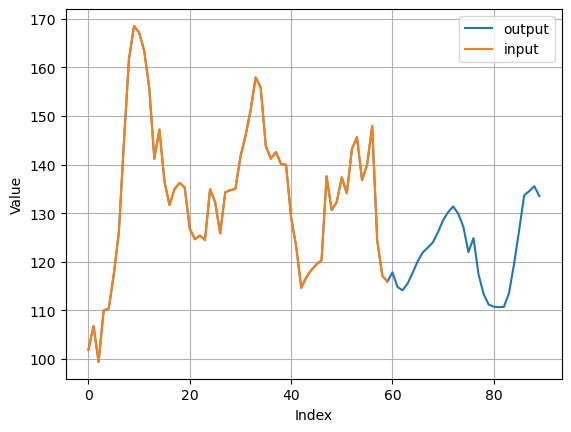

In [197]:


test_mean = np.mean(test)
final_result = test - test_mean
for i in tqdm(range(30)):
    _single_output = model.predict(
        final_result[np.newaxis, i:i+INPUT_DAYS, np.newaxis], verbose=0)
    final_result = np.concatenate((final_result, _single_output[0]), axis=0)    

# Subtract mean했던거 다시 더해주기
_summit = final_result[-30:]
_summit = _summit + test_mean

plt.figure()
plt.plot(final_result+test_mean, label='output')
plt.plot(test, label='input')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


## output xlsx file 생성

In [198]:
import datetime

current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
df = pd.DataFrame({'date': np.array(range(1,31)), 'flux': _summit})

# DataFrame을 엑셀 파일로 내보내기
file_name = f'/home/competition/data/data/dev/{current_time}_output_{loss_history[-1]}.xlsx'
df.to_excel(file_name, index=False)

model_name = f'/home/competition/data/data/dev/{current_time}_model_{loss_history[-1]}.h5'
model.save(model_name)


/home/competition/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
